In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, train_test_split
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import classification_report,confusion_matrix, plot_confusion_matrix
from statsmodels.stats.proportion import proportions_ztest,confint_proportions_2indep

In [2]:
raw = pd.read_csv("sentencing_fips_pop2010 2.csv")

In [3]:
def drop_error_value(df):
    df_temp = df.copy()
    df_temp = df_temp[~((df_temp['spyrs']>=99)|(df_temp['life']=='Y'))]
    df_temp['sp_cj_total_days'] = (df_temp['sp_total_days'])+(df_temp['cj_total_days'])
    df_clean = df_temp[~((df_temp['sp_cj_total_days']<=7) & (df_temp['totpts']>44))]
    
    return df_clean

In [8]:
def feat_prep(df):
    df_temp = df.copy()
    df_temp['gender_ind']=[1 if x=='MALE' else 0 for x in df_temp['gender']]
    df_temp = pd.concat([df_temp,pd.get_dummies(df_temp['clfely'], prefix='clfely')],axis=1)
    df_temp['sent_year']=df_temp["sentdte"].str[:4]
    df_temp['lsviol']=[0 if x==0 else 1 for x in df_temp['lsviol']]
    df_temp['rpviol']=[0 if x==0 else 1 for x in df_temp['rpviol']]
    df_temp['faviol']=[0 if x==0 else 1 for x in df_temp['faviol']]
    
    return df_temp

In [4]:
raw.shape

(1354399, 43)

In [5]:
def sp_county_crime_type(county, crime_type, df):
    match_ind = ''
    if crime_type == 'drug':     ### Expendable
        match_ind = '893.*'
        
    df = df[df['statut'].str.match(match_ind)== True]
    
    df =df[df['county']== county]
    
    return df

In [10]:
def model_gen(df,feat_col, mod = 'rf'):
    X = df.loc[:,feat_col]
    y = df['Y']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)
    
    if mod == 'rf':
        model = RandomForestClassifier(n_estimators=500,random_state=7)
        model.fit(X_train, y_train)
        dev_pred = model.predict(X_test)
        print('Random Forest Accuracy %.3f' %metrics.accuracy_score(y_test, dev_pred))
        print('Random Forest Precision %.3f' %metrics.precision_score(y_test, dev_pred))
        print('Random Forest Recall %.3f' %metrics.recall_score(y_test, dev_pred))
    
    df['propensity'] = model.predict_proba(X)[:,1]  
    
    return model,df

In [6]:
raw_clean = drop_error_value(raw)

In [7]:
df_drug =sp_county_crime_type(county='pinellas',crime_type='drug',df= raw_clean)

In [9]:
df_drug_model = feat_prep(df_drug)

In [11]:
df_drug_model.shape

(42267, 51)

In [13]:
df_drug_model['Y']=[1 if x =='BLACK' else 0 for x in df_drug_model['race']]

In [14]:
df_drug_model['Y'].value_counts()

0    27286
1    14981
Name: Y, dtype: int64

In [15]:
feat_col = ['gender_ind','clfely_1ST DEGREE','clfely_3RD DEGREE'
                               ,'clfely_LIFE','clfely_1ST/LIFE','sent_year','totpts','lsviol','rpviol','faviol']


model_rfc,df_drug_output = model_gen(df_drug_model,feat_col, mod = 'rf')

Random Forest Accuracy 0.646
Random Forest Precision 0.505
Random Forest Recall 0.408


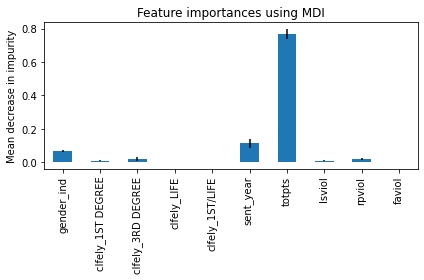

In [16]:
feature_names = [x for x in feat_col]
importances = model_rfc.feature_importances_
std = np.std([tree.feature_importances_ for tree in model_rfc.estimators_], axis=0)

forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()